## Assignment 02 
Name - **D.M.S.S.Dissanayake**   
Index No - **190155L**

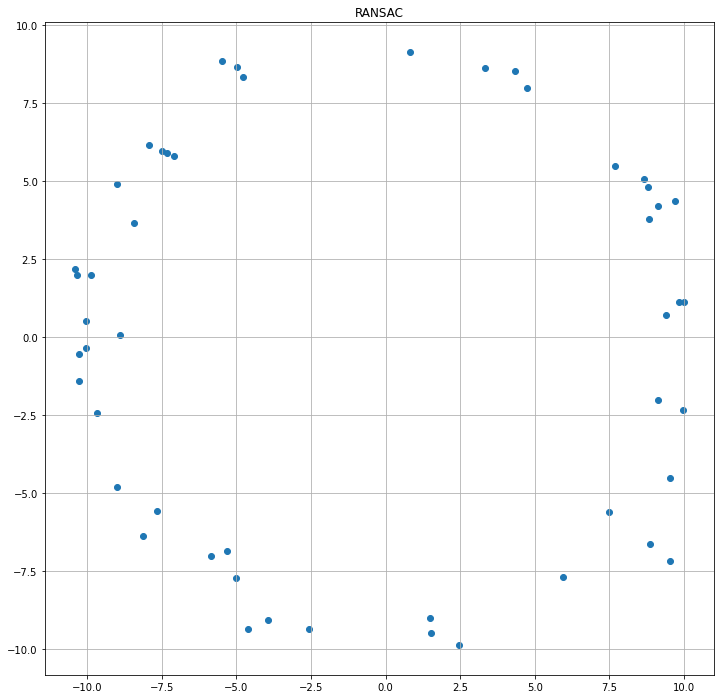

In [2]:
import numpy as np
from scipy.optimize import minimize
from scipy import linalg
import matplotlib.pyplot as plt
# np.random.seed(0)
N = 100
half_n = N// 2
r = 10
s = r/16
t = np.random.uniform (0 , 2*np.pi, half_n)
n = s*np.random.randn(half_n)
x, y = (r+n)*np.cos(t), (r+n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
m, b = -1, 2
x = np.linspace(-12, 12 ,half_n)
y = m*x + b + s*np.random.randn(half_n)
X_line = np.hstack((x.reshape(half_n, 1), y.reshape(half_n, 1)))
X = np.vstack((X_circ, X_line ))

fig,ax = plt.subplots(1,1,figsize=(12,12))
ax.set_title('RANSAC')
ax.grid('on')
plt.scatter(X_circ[:,0],X_circ[:,1])
plt.show()

In [7]:
def RANSAC_circle(Data_set,No_of_iterations,t):
    max_inlinear_count=0
    best_fit_circle_coefficient=[]
    best_sample_points=[]
    
    for sample in range(0,No_of_iterations+1):
        point1,point2,point3=random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1),random.randint(0,len(Data_set)-1)
        x1,x2,x3=Data_set[point1][0],Data_set[point2][0],Data_set[point3][0]
        y1,y2,y3=Data_set[point1][1],Data_set[point2][1],Data_set[point3][1]

        P = np.array([[2*x1 , 2*y1 , 1] , [2*x2 , 2*y2 , 1] , [2*x3 , 2*y3 , 1]])
        if (np.linalg.det(P)==0):
            continue
        K=np.array([[x1*2 + y1*2] , [x2*2 + y2*2] , [x3*2+y3*2]])(-1)
        answer=np.linalg.inv(P)@ K
        g,f,c=answer[0][0],answer[1][0],answer[2][0]
        radius=np.sqrt(g*2+f*2-c)
        if radius>20:
            continue
        center=[-g,-f]

        inlinear_count=0
        for i in range(0,len(Data_set)):
            distance=abs(np.sqrt((Data_set[i][0]-center[0])*2 + (Data_set[i][1]-center[1])*2) - radius)
            if distance < t:
                inlinear_count+=1
        if inlinear_count>max_inlinear_count:
            max_inlinear_count=inlinear_count
            best_fit_circle_coefficient=[g,f,c]
            best_sample_points=np.array([Data_set[point1],Data_set[point2],Data_set[point3]])
    return(best_fit_circle_coefficient,best_sample_points,max_inlinear_count)

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import random

s=3
t=1
e=0.5
p=0.99
No_of_iterations=int(np.log(1-p)/np.log(1-(1-e)**s))

ransac_circle_coeff,ransac_sample,ransac_inlinear_count=RANSAC_circle(X,No_of_iterations,t)

F,G,C=ransac_circle_coeff[0],ransac_circle_coeff[1],ransac_circle_coeff[2]
R=np.sqrt(G*2+F*2-C)

#Finding Inlenear and Outlinear of the RANSAC Estimated Circle
In,Out=[],[]
for point in X:
    d=abs(np.sqrt((point[0]+G)*2+(point[1]+F)*2)-R)
    if d<t:
        In.append(point)
    else:Out.append(point)

Inlin = np.array(In).T
Outlin = np.array(Out).T
Samp = ransac_sample.T

print("Number of Itarations =",No_of_iterations)
print("RANSAC Estimated circle Inlinear Count =",ransac_inlinear_count)

TypeError: 'numpy.ndarray' object is not callable

In [52]:
best_circle_coeff,best_sample,best_inlinear_count=RANSAC_circle(X,10000,t)
best_F,best_G,best_C=best_circle_coeff[0],best_circle_coeff[1],best_circle_coeff[2]
best_R=np.sqrt(best_G*2+best_F*2-best_C)

bestt_sample=best_sample.T
print("best fitting circle Inlinear Count =",best_inlinear_count)

<ipython-input-50-8c7c2abf2999>:24: RuntimeWarning: invalid value encountered in sqrt
  distance=abs(np.sqrt((Data_set[i][0]-center[0])*2 + (Data_set[i][1]-center[1])*2) - radius)
<ipython-input-50-8c7c2abf2999>:17: RuntimeWarning: invalid value encountered in sqrt
  radius=np.sqrt(g*2+f*2-c)


best fitting circle Inlinear Count = 58


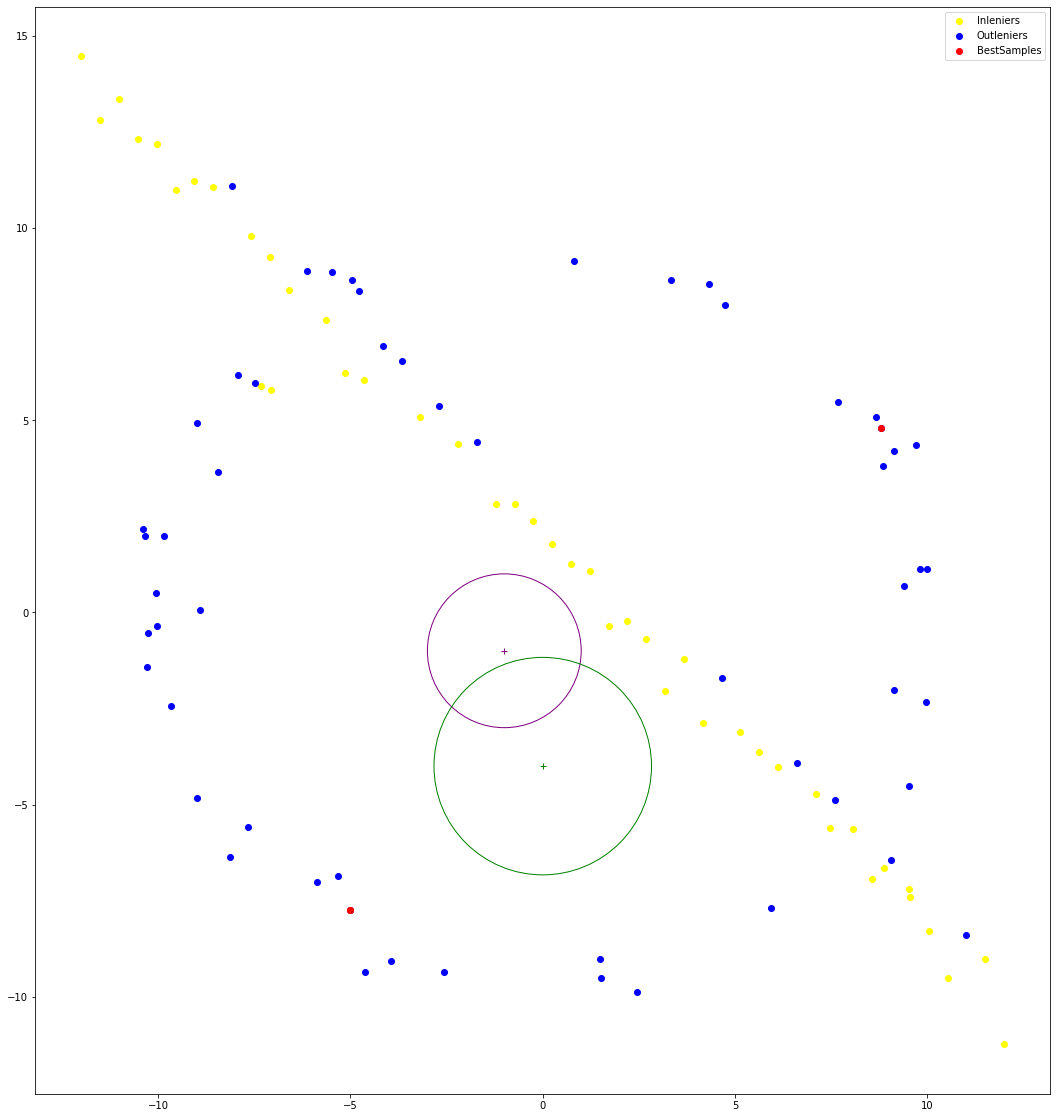

In [56]:
#plotting
figure, axes = plt.subplots( 1, figsize=(20,20) )

ransac_circle = plt.Circle((-G,-F), R, fill=False, color="purple" ,label="RANSAC")
best_fitting_circle = plt.Circle((-best_G,-best_F), best_R, fill=False, color="green" ,label="Best Fitting")

axes.scatter(Inlin[0],Inlin[1], color="yellow" , label="Inleniers")
axes.scatter(Outlin[0],Outlin[1], color="blue" , label="Outleniers")
axes.scatter(bestt_sample[0] ,bestt_sample[1], color="red" , label="BestSamples")
axes.plot(-G,-F,"+",color="purple")
axes.plot(-best_G,-best_F,"+",color="green")
axes.set_aspect( 1 )
axes.add_artist( ransac_circle )
axes.add_artist( best_fitting_circle )
plt.legend(loc ="upper right")
plt.show()

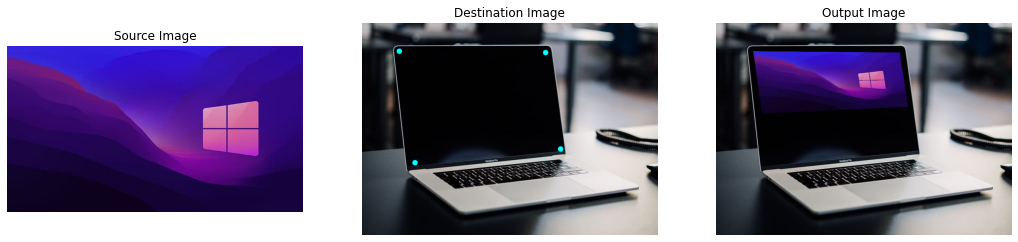

In [15]:
# Question 2
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

img_dst = cv.imread('macbook.jpg',cv.IMREAD_COLOR)
img_src = cv.imread('windowswallpaper.jpeg',cv.IMREAD_COLOR)

def corner_points(img):
    pts = []
    pts.append([0,0])
    pts.append([img_src.shape[1]-1,0])
    pts.append([0,img_src.shape[1]-1])
    pts.append([img_src.shape[1]-1,img_src.shape[1]-1])
    return pts

def draw_circle(event, x, y, flags, param):
   global pts_dst
   if event == cv.EVENT_LBUTTONDOWN:
        pts_dst.append((x, y))
        cv.circle(img_dst, (x, y), 8, (255, 255, 0), -1)

pts_src = np.array(corner_points(img_src))
pts_dst = []

cv.namedWindow('image')
cv.setMouseCallback('image',draw_circle)
cv.imshow('image', img_dst)
cv.waitKey(0)
cv.destroyAllWindows()

pts_dst = np.array(pts_dst) 
# Calculate Homography
h, status = cv.findHomography(pts_src, pts_dst)
# Warp source image to destination based on homography
im_out = cv.warpPerspective(img_src, h, (img_dst.shape[1],img_dst.shape[0]))
im_out = cv.addWeighted(im_out, 1, cv.imread('macbook.jpg',cv.IMREAD_COLOR), 1, 0.0)

fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].imshow(cv.cvtColor(img_src, cv.COLOR_BGR2RGB))
ax[0].set_title('Source Image')
ax[0].axis('off')
ax[1].imshow(cv.cvtColor(img_dst, cv.COLOR_BGR2RGB))
ax[1].set_title('Destination Image')
ax[1].axis('off')
ax[2].imshow(cv.cvtColor(im_out, cv.COLOR_BGR2RGB))
ax[2].set_title('Output Image')
ax[2].axis('off')
plt.show()

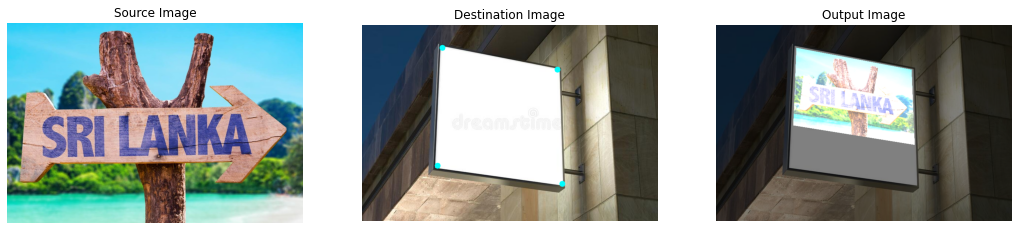

In [21]:
img_src = cv.imread('travelsrilanka.png',cv.IMREAD_COLOR)
img_dst = cv.imread('signboard.jpg',cv.IMREAD_COLOR)

def corner_points(img):
    pts = []
    pts.append([0,0])
    pts.append([img_src.shape[1]-1,0])
    pts.append([0,img_src.shape[1]-1])
    pts.append([img_src.shape[1]-1,img_src.shape[1]-1])
    return pts

def draw_circle(event, x, y, flags, param):
   global pts_dst
   if event == cv.EVENT_LBUTTONDOWN:
        pts_dst.append((x, y))
        cv.circle(img_dst, (x, y), 8, (255, 255, 0), -1)

pts_src = np.array(corner_points(img_src))
pts_dst = []

cv.namedWindow('image')
cv.setMouseCallback('image',draw_circle)
cv.imshow('image', img_dst)
cv.waitKey(0)
cv.destroyAllWindows()

pts_dst = np.array(pts_dst) 
# Calculate Homography
h, status = cv.findHomography(pts_src, pts_dst)
# Warp source image to destination based on homography
im_out = cv.warpPerspective(img_src, h, (img_dst.shape[1],img_dst.shape[0]))
im_out = cv.addWeighted(im_out, 1, cv.imread('signboard.jpg',cv.IMREAD_COLOR), 0.5, 0.0)

fig,ax = plt.subplots(1,3,figsize=(18,6))
ax[0].imshow(cv.cvtColor(img_src, cv.COLOR_BGR2RGB))
ax[0].set_title('Source Image')
ax[0].axis('off')
ax[1].imshow(cv.cvtColor(img_dst, cv.COLOR_BGR2RGB))
ax[1].set_title('Destination Image')
ax[1].axis('off')
ax[2].imshow(cv.cvtColor(im_out, cv.COLOR_BGR2RGB))
ax[2].set_title('Output Image')
ax[2].axis('off')
plt.show()